In [1]:
import pandas as pd

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

2023-01-22 19:13:07.797675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv('dataset_processed_v2.csv.zip')
df.shape

(1286916, 27)

# Merge TS Features

In [5]:
event_level_fill_df = pd.read_csv('event_level_fill_rate.csv')
df = df.merge(event_level_fill_df, on='event_date', how='left')

seat_level_df = pd.read_csv('seat_level_lagged_isattended.csv.zip')
df = df.merge(seat_level_df, on=['event_date', 'SeatUniqueID'], how='left')

In [6]:
target_variable = 'isAttended'

numerical_features = ['Price', 'Tenure', 'event_sale_date_diff', 'sale_resale_date_diff', 'ResalePrice',
                      'event_resale_date_diff', 'fill_rate_lag_1', 'fill_rate_lag_2', 'fill_rate_lag_3',]

categorical_features = ['PC1', 'paid', 'status', 'isHost', 'TicketClass', 'Term', 'Season', 'Resold', 'isSTM',
                       'acct_type_desc_processed', 'plan_event_name_processed', 'comp_name_processed',
                        'class_name_processed', 'TicketType_processed', 'isAttended_lagg_1', 'isAttended_lagg_2',
                        'isAttended_lagg_3', 'SeatType']

In [7]:
for col in categorical_features:
    df[col] = df[col].apply(lambda x: str(x) if pd.notna(x) else None)
    print(col, df[col].nunique())

PC1 31
paid 3
status 4
isHost 2
TicketClass 5
Term 5
Season 2
Resold 1
isSTM 2
acct_type_desc_processed 8
plan_event_name_processed 3
comp_name_processed 2
class_name_processed 11
TicketType_processed 11
isAttended_lagg_1 2
isAttended_lagg_2 2
isAttended_lagg_3 2
SeatType 2


In [8]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"), # there are a few missing values
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, numerical_features),
    (transformer_cat, categorical_features),
)

In [9]:
train_df = df[df['isAttended'] != '???'].copy()
test_df = df[df['isAttended'] == '???'].copy()

In [10]:
train_df['isAttended'] = train_df['isAttended'].replace({'Yes': 1, 'No': 0})

In [11]:
X = train_df[numerical_features + categorical_features].copy()
y = train_df[target_variable].copy()

In [12]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75, random_state=99)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [13]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])

2023-01-22 19:14:16.836423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', AUC()],
)

In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
1697/1697 [==============================] - 141s 82ms/step - loss: 0.4177 - binary_accuracy: 0.8275 - auc: 0.7675 - val_loss: 0.3728 - val_binary_accuracy: 0.8501 - val_auc: 0.8081
Epoch 2/200
1697/1697 [==============================] - 154s 91ms/step - loss: 0.3789 - binary_accuracy: 0.8484 - auc: 0.7991 - val_loss: 0.3680 - val_binary_accuracy: 0.8516 - val_auc: 0.8125
Epoch 3/200
1697/1697 [==============================] - 154s 91ms/step - loss: 0.3740 - binary_accuracy: 0.8504 - auc: 0.8044 - val_loss: 0.3669 - val_binary_accuracy: 0.8522 - val_auc: 0.8146
Epoch 4/200
1697/1697 [==============================] - 166s 98ms/step - loss: 0.3712 - binary_accuracy: 0.8515 - auc: 0.8080 - val_loss: 0.3656 - val_binary_accuracy: 0.8534 - val_auc: 0.8153
Epoch 5/200
1697/1697 [==============================] - 164s 96ms/step - loss: 0.3693 - binary_accuracy: 0.8527 - auc: 0.8099 - val_loss: 0.3641 - val_binary_accuracy: 0.8543 - val_auc: 0.8168
Epoch 6/200
1697/1697 [=======

<AxesSubplot: title={'center': 'AUC'}>

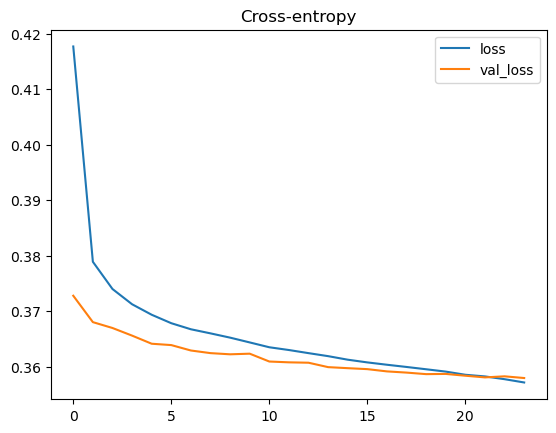

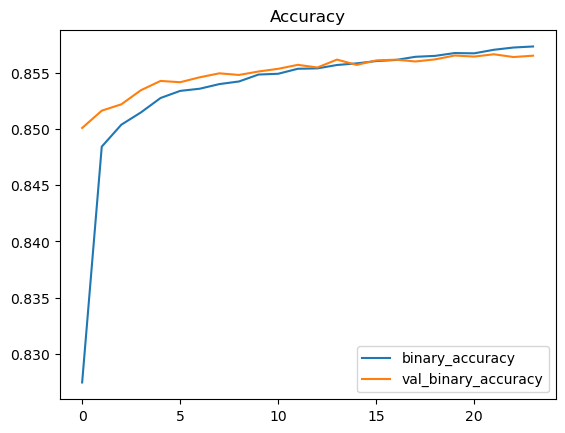

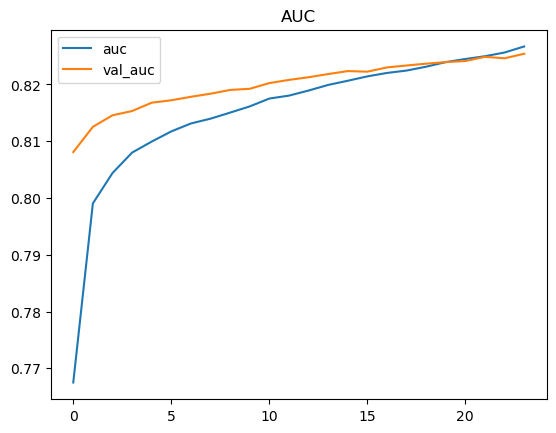

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")

In [19]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from skopt import BayesSearchCV

In [ ]:
# batch_size = [256, 512]
# epochs = [20, 30]
# optimizer = ['RMSprop', 'Adam']
# neurons = [512, 1024]


# def create_model(neurons=neurons, epochs=epochs, optimizer=optimizer, batch_size=batch_size):
#     model = Sequential()
#     model.add(Dense(neurons, input_dim=784, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(neurons, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model


# model_BayesianOptimization = KerasClassifier(build_fn=create_model, verbose=0)

# param_opt = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, optimizer=optimizer)

In [ ]:
# bayesian = BayesSearchCV(
#      model_BayesianOptimization,
#      param_opt,
#      n_iter=32,
#      random_state=random_state,
#      cv=3,
#      verbose = 0, n_jobs=1
#  )

# bayesian_result = bayesian.fit(X_train, Y_train)